In [1]:
import pandas as pd

In [11]:
%load_ext autoreload

In [2]:
full_channel_df = pd.read_json('../empirical_data/LUNA_FullChannel_GDAX_20220511_17hr.json', lines=True)

In [3]:
ticker_df = pd.read_json('../empirical_data/LUNA_Ticker_GDAX_20220511_17hr.json', lines=True)

In [4]:
full_channel_df.time = pd.to_datetime(full_channel_df.time)
full_channel_df['timestamp'] = full_channel_df['time'].astype('int64')

ticker_df.time = pd.to_datetime(ticker_df.time)
ticker_df['timestamp'] = ticker_df['time'].astype('int64')

In [5]:
ticker_df.sort_values(by='sequence', inplace=True)
left_border = ticker_df.iloc[:-1].sequence.reset_index(drop=True)
right_border = ticker_df.iloc[1:].sequence.reset_index(drop=True)
ticker_df = ticker_df.iloc[:-1].copy()
ticker_df['sequence_start'] = left_border
ticker_df['sequence_end'] = right_border

In [6]:
ticker_df['mid_price'] = (ticker_df['best_bid'] + ticker_df['best_ask']) / 2

In [7]:
def find_matching_range(sequence):
    mask = (ticker_df.sequence_start <= sequence) & (sequence < ticker_df.sequence_end)
    if mask.any():
        return ticker_df[mask].sequence.iloc[0]


# full_channel_df['ticker_sequence'] = full_channel_df.sequence.apply(find_matching_range)
# full_channel_df.to_csv('full_channel_df_with_ticker_sequence.csv', index=False)
full_channel_df = pd.read_csv('full_channel_df_with_ticker_sequence.csv')
full_channel_df.dropna(subset=['ticker_sequence'], inplace=True)
orders_df = full_channel_df.merge(ticker_df.drop(columns=['price', 'timestamp', 'side', 'time', 'type']), left_on='ticker_sequence', right_on='sequence', how='inner')

In [8]:
orders_df.columns

Index(['order_id', 'order_type', 'size', 'price', 'client_oid', 'type', 'side',
       'product_id_x', 'time', 'sequence_x', 'remaining_size', 'trade_id_x',
       'maker_order_id', 'taker_order_id', 'reason', 'funds', 'old_size',
       'new_size', 'timestamp', 'ticker_sequence', 'sequence_y',
       'product_id_y', 'open_24h', 'volume_24h', 'low_24h', 'high_24h',
       'volume_30d', 'best_bid', 'best_ask', 'trade_id_y', 'last_size',
       'sequence_start', 'sequence_end', 'mid_price'],
      dtype='object')

In [9]:
from momentum import calculate_momentum
from plot_utils import plot_cumulative_momentum, plot_mid_price, plot_mid_price_with_momentum

In [22]:
from concurrent.futures import ProcessPoolExecutor

%autoreload 1
from preprocessing import add_size_to_sample


canceled_df = orders_df[orders_df.reason == 'canceled'].copy()


CONCURRENCY = 10
BATCH_SIZE = 1000


orders_received_df = orders_df[orders_df.type == 'received']
# def add_size_to_canceled(row):
#     if row.reason != 'canceled':
#         return None
#     mask = (orders_received_df.order_id == row.order_id)
#     if mask.any():
#         return orders_received_df[mask].iloc[0]['size']


# canceled_df_small = canceled_df.iloc[:10000].copy()
def set_size_to_canceled(canceled_df):
    final_series = None

    with ProcessPoolExecutor(CONCURRENCY) as executor:
        for canceld_df_batch_idx in range(0, canceled_df.shape[0], BATCH_SIZE):
            print('Processing batch ', canceld_df_batch_idx, ' to ', canceld_df_batch_idx + BATCH_SIZE)
            futures = []
            canceled_df_batch = canceled_df.iloc[canceld_df_batch_idx:canceld_df_batch_idx + BATCH_SIZE]
            for i in range(0, canceled_df_batch.shape[0], canceled_df_batch.shape[0] // CONCURRENCY):
                sample = canceled_df_batch.iloc[i:i + canceled_df_batch.shape[0] // CONCURRENCY].copy()
                print('Submitting task of sample ', i, ' to ', i + canceled_df_batch.shape[0] // CONCURRENCY)
                future = executor.submit(add_size_to_sample, orders_received_df, sample, axis=1)
                futures.append(future)
            for future in futures:
                if final_series is None:
                    final_series = future.result()
                else:
                    final_series = pd.concat([final_series, future.result()])

    return final_series


# size = set_size_to_canceled(canceled_df)
# canceled_df['size'] = size
# canceled_df.to_csv('canceled_df_with_size.csv', index=False)

canceled_df = pd.read_csv('canceled_df_with_size.csv')

canceled_mask = (orders_df.reason == 'canceled') & orders_df.order_id.isin(canceled_df.order_id)
canceled_index = orders_df[canceled_mask].index
canceled_df.index = canceled_index
orders_df.loc[canceled_mask, 'size'] = canceled_df['size']

In [23]:
orders_df[orders_df.reason == 'canceled']['size']

12            NaN
19            NaN
28            NaN
35            NaN
45        127.757
           ...   
752525    341.318
752539    118.866
752542     10.000
752548     10.000
752581     10.000
Name: size, Length: 205107, dtype: float64

In [24]:
buy_nan_size_mask = (orders_df.order_type == 'market') & orders_df['size'].isna() & (orders_df.side == 'buy')
orders_df.loc[buy_nan_size_mask, 'size'] = orders_df.loc[buy_nan_size_mask, 'funds'] / orders_df.loc[buy_nan_size_mask, 'best_ask']

sell_nan_size_mask = (orders_df.order_type == 'market') & orders_df['size'].isna() & (orders_df.side == 'sell')
orders_df.loc[sell_nan_size_mask, 'size'] = orders_df.loc[sell_nan_size_mask, 'funds'] / orders_df.loc[sell_nan_size_mask, 'best_bid']

orders_df[(orders_df.order_type == 'market') & orders_df['size'].isna()].shape

(0, 34)

In [25]:
orders_df = orders_df[['timestamp', 'order_id', 'price', 'best_bid', 'best_ask', 'mid_price', 'side', 'order_type', 'reason', 'size', 'time']]

## Velocities

### Limit buy
![alt text](limit_buy.png "limit buy")

### Limit sell
![alt text](limit_sell.png "limit sell")

### Limit buy cancel
![alt text](limit_buy_cancel.png "limit buy cancel")

### Limit sell cancel
![alt text](limit_sell_cancel.png "limit sell cancel")

### Active area momentum
![alt text](active_area_momentum.png "active area momentum")

### Passive area momentum
![alt text](passive_area_momentum.png "passive area momentum")


In [26]:
delta_t_ns = 100_000_000
diff_t_ns = full_channel_df.timestamp.max() - full_channel_df.timestamp.min()
start_t_ns = full_channel_df.timestamp.min() + diff_t_ns // 3
end_t_ns = full_channel_df.timestamp.max() - diff_t_ns // 3

# alpha = (ticker_df.price.max() - ticker_df.price.min()) / 4
alpha = 0.5

In [27]:
from momentum import calculate_momentum_multiproc


cumulative_momentum, mean_price_full, accum_df = calculate_momentum_multiproc(
    orders_df,
    alpha,
    delta_t_ns,
    start_t_ns,
    end_t_ns,
    area='passive',
    concurrency=10
)

100%|██████████| 1198/1198 [00:03<00:00, 366.22it/s]


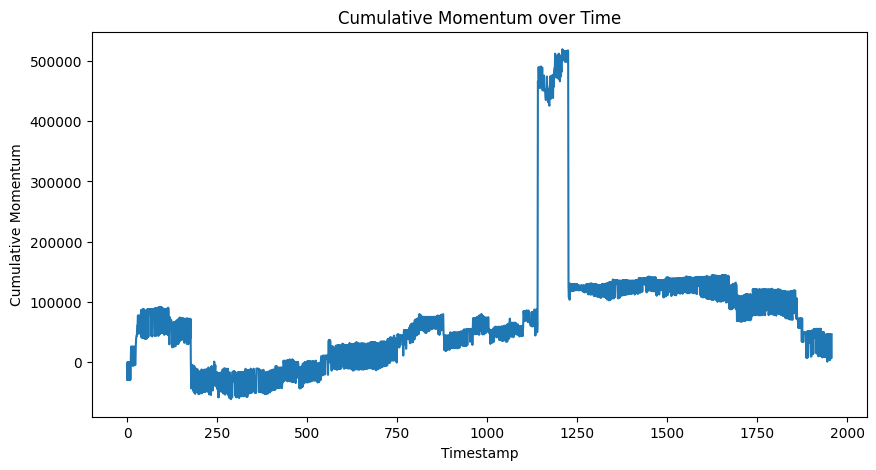

In [28]:
plot_cumulative_momentum(cumulative_momentum)

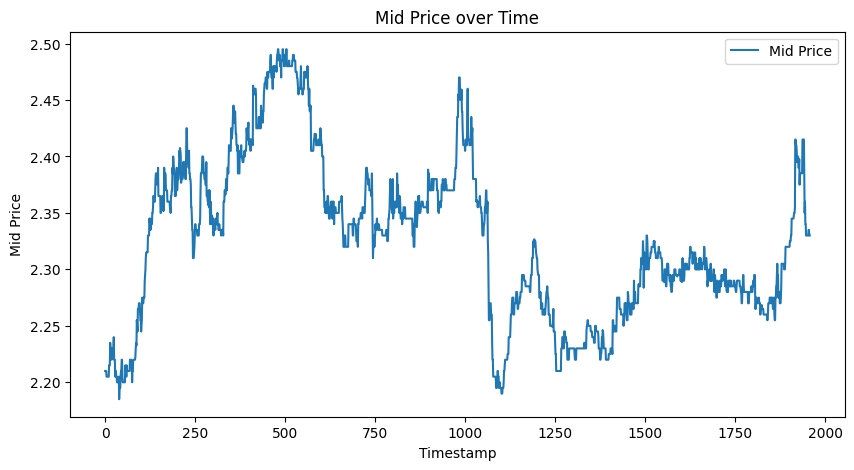

In [29]:
plot_mid_price(mean_price_full)

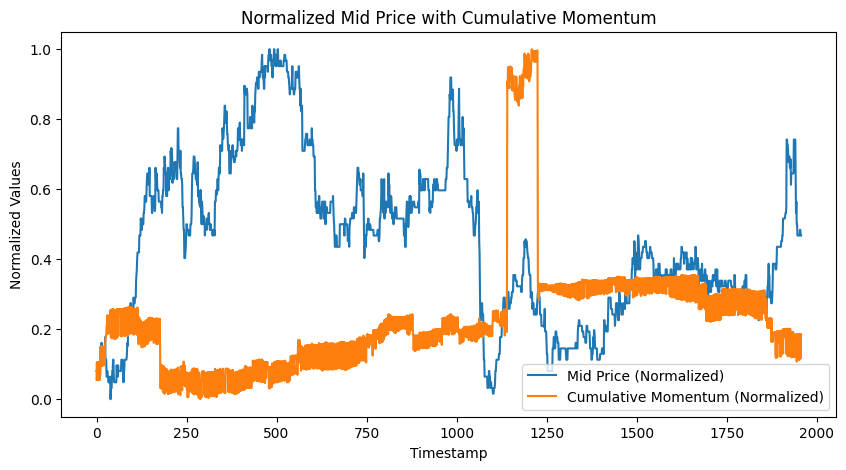

In [30]:
plot_mid_price_with_momentum(mean_price_full, cumulative_momentum)

When order_type is **NaN**, type can be **open**, **match**, **done**, **change** (order change/trade)  
When order_type is **limit** or **market**, type is **received** (order creation)  

When order_type is **NaN**, reason can be **NaN**, **filled**, **canceled**  
When order_type is **limit** or **market**, reason can be **NaN**  

